In [ ]:
!pip install shap
!pip install ggseg

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import matplotlib.cm as cm
from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb

import seaborn as sns
import ggseg

import pylab as pl
from IPython.display import display, clear_output
import ipywidgets as widgets

from itertools import chain

In [2]:
import shap
# import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold , StratifiedGroupKFold
from sklearn.model_selection import train_test_split , RepeatedKFold, cross_validate , cross_val_score, KFold 

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics  import f1_score,accuracy_score, precision_score, recall_score
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix

from sklearn.impute import KNNImputer

In [3]:
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import RidgeClassifier

import warnings
warnings.filterwarnings("ignore")

In [19]:
dataSet = pd.read_csv('dataSet.csv')
dataSet = dataSet.drop('Unnamed: 0', 1)
dataSet = dataSet.drop(['scanid'], 1)

In [24]:
# print(dataSet.shape)
# # dataSet = dataSet.loc[dataSet['cohort'] !='PREDICT-HD']
# print(dataSet.shape)head

In [20]:
print(dataSet.shape)
dataSet = dataSet[dataSet['Ventricle-slope'] != 0]
print(dataSet.shape)
dataSet = dataSet.dropna(subset=['Ventricle-slope'])
print(dataSet.shape)
# dataSet = dataSet[dataSet['Ventricle-slope'] >-700]
print(dataSet.shape)

dataSet['isMale'] = (dataSet['sex']== 'male').astype(int)
dataSet['isFemale'] = (dataSet['sex'] == 'female').astype(int)

(1027, 268)
(879, 268)
(844, 268)
(844, 268)


In [26]:
# Effect of removing one dataset
# dataSet = dataSet[dataSet['cohort'] == 'PREDICT-HD'].copy()

In [21]:
patients = dataSet.loc[(dataSet['group'] == 'pre-HD') 
                       | (dataSet['group'] == 'symp-HD')]

patients = patients.reset_index(drop=True)
print('Number of baseline scans from HD individuals:', patients.shape)

healthy = dataSet.loc[dataSet['group'] == 'control']
healthy = healthy.reset_index(drop=True)
print('Number of baseline scans from Control subjects:', healthy.shape)

Number of baseline scans from HD individuals: (540, 270)
Number of baseline scans from Control subjects: (304, 270)


In [22]:
dataSet = dataSet.drop_duplicates(subset='subjid', keep="first")
dataSet.groupby([ 'group'])['ageAtscan'].std()

group
control    10.650964
pre-HD     10.513512
symp-HD     9.570543
Name: ageAtscan, dtype: float64

In [23]:
# remove outliers from each group {healthy and HD patients}
def remove_outliers(group , column):
    Q1 = np.percentile(group[column], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(group[column], 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1

    print("Old Shape: ", group.shape)

    # Upper bound
    upper = np.where(group[column] >= (Q3 + 3*IQR))
    # Lower bound
    lower = np.where(group[column] <= (Q1 - .4*IQR))

    ''' Removing the Outliers '''
    group.drop(upper[0], inplace = True)
    # group.drop(lower[0], inplace = True)

    print("New Shape: ", group.shape)
    return group

In [24]:
# patients = remove_outliers(patients , 'Ventricle-slope')
# patients = patients.reset_index(drop=True)

# healthy = remove_outliers(healthy, 'Ventricle-slope')
# healthy = healthy.reset_index(drop=True)

# dataSet = pd.concat([patients , healthy])
# dataSet = dataSet.reset_index(drop=True)

In [25]:
patients = patients[~patients['subjid'].isin(['R900802016','R496193759','R072584667','304106'])]
ind1 = patients['subjid'].isin(['R993317808', '586980','R414729420','R880103664','561294','R941921814','254395','R544158996','50_24.out','R956410576','R373291136',  '1845','R823032659','R71468748X','R540517099','R535283036','R490351896','R399319137','R884620171','R560586658','R171064892','163666','446941','R347560119','R166560972','219576','R433993862','R242586931','50_51.out','R991995144','50_12.out','R674983560','432567','R899436679','446612','304106''R072584667','R496193759','R162078334','R235149988','R900802016','66217'])
ind2 = patients['Ventricle-slope'] > 0
print(patients.shape)
patients = patients[~ind1 | ind2].copy()
patients = patients.reset_index(drop = True)
print(patients.shape)

patients.loc[patients['WM-hypointensities']>.003 , 'WM-hypointensities'] = np.nan

(536, 270)
(520, 270)


In [26]:
imputer = KNNImputer(n_neighbors=10, weights="uniform")
numeric_columns = patients.select_dtypes(include='number').columns
patients.loc[:,numeric_columns] = pd.DataFrame(imputer.fit_transform(patients[numeric_columns]), columns=numeric_columns)

In [27]:
patients = patients.sample(frac=1, random_state=68)

In [34]:
# for i,col in enumerate(dataSet.columns):
#     print(i,col)

In [28]:
def Train_model(data , classifier):
        print('data size: ' , data.shape)

        groups = data['subjid']
        y = data['Ventricle-slope'].values
        threshold = np.median(y)  
        X = data.drop(columns = 'Ventricle-slope')

        y_cat = pd.qcut(y, 20, labels=range(20))
        #plt.plot(y,y_cat,'.')
        train_index, test_index = next(StratifiedGroupKFold(n_splits=10 , shuffle=True, random_state= 68).split(X, y_cat , groups= groups))
        X_train, X_test, y_train, y_test = X.iloc[train_index,:].copy() , X.iloc[test_index,:].copy() , y[train_index], y[test_index]  

        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y_cat)
        groups_train = X_train['subjid']
        X_train = X_train.drop(columns = 'subjid')
        X_test = X_test.drop(columns = 'subjid')
        X = X.drop(columns = 'subjid')

        y_cat = pd.qcut(y_train, 20, labels=range(20))
        
        skf_gen = StratifiedGroupKFold(n_splits=9,shuffle=True, random_state= 68).split(X_train, y_cat , groups= groups_train)
        # print('Train size: ', X_train.shape)

        y_train = y_train < threshold    
        y_test = y_test < threshold  

        cv_results = cross_validate(classifier, X_train, y_train, cv = skf_gen, scoring=['accuracy','f1'],
                                     return_train_score=True, verbose = 0, n_jobs= -1) 

        cv_results = pd.DataFrame(cv_results)
        print( "Validation Accuracy : %0.2f  \u00B1  %0.2f" % (np.mean(cv_results['test_accuracy'])  ,  np.std(cv_results['test_accuracy'])))
        print( "Validation f1 : %0.2f  \u00B1  %0.2f" % (np.mean(cv_results['test_f1'])  ,  np.std(cv_results['test_f1'])))       
        print()
        print( "Train Accuracy : %0.2f  \u00B1  %0.2f" % (np.mean(cv_results['train_accuracy'])  ,  np.std(cv_results['train_accuracy'])))
        print( "Train f1 : %0.2f  \u00B1  %0.2f" % (np.mean(cv_results['train_f1'])  ,  np.std(cv_results['train_f1'])))       
        print()

        classifier.fit(X_train,y_train)
        pred = classifier.predict(X_test)
        print('Test size: ', X_test.shape)
        print('Test Accuracy:   %0.2f' %accuracy_score(y_test,pred))
        print('Test f1:  %0.2f' %f1_score(y_test,pred))

        return [X, y , X_test, y_test, classifier]


In [16]:
def check_box_callback(x, q):
    global included
    included = []
    for feature, checkbox in biomarkers_checkboxes.items():
        ischecked = checkbox.children[0].value
        if ((feature == 'Sex') & ischecked ): included += [268,269]
        if ((feature == 'Age') & ischecked ): included.append(265)
        if ((feature == 'CAG') & ischecked) : included.append(258)
        if ((feature == 'CAP') & ischecked) : included.append(266)
        if ((feature == 'TMS') & ischecked) : included.append(261)
        if ((feature == 'SDMT') & ischecked) : included.append(262)
        if ((feature == 'SWR') & ischecked) : included.append(263)
        if ((feature == 'cUHDRS') & ischecked) : included.append(264)

        if ((feature == 'Ventricular') & ischecked) : included += [1,2,9,10,14,18]
        if ((feature == 'WM-hypointensities') & ischecked) : included.append(19)

        if ((feature == 'Subcortical') & ischecked) : included += list(chain(range(3,9) , range(11,14), range(15,18) , range(21,27)))
        if ((feature == 'head size') & ischecked) : included.append(41)

#         if ((feature == 'Cortical Thickness') & ischecked) : included.append(75)       
        if ((feature == 'Cortical Thickness') & ischecked) : included += list(chain(range(42,76) , range(77,111)))
        if ((feature == 'Cortical Area') & ischecked) : included += list(chain(range(113,183)))
        if ((feature == 'Cortical Vol') & ischecked) : included += list(chain(range(184,252)))
                    
# Checkboxes to select visible species.
biomarkers_checkboxes = {}
for feature in np.array(['Sex', 'Age' ,'CAG','CAP', 'TMS', 'SDMT', 'SWR','cUHDRS', 'Ventricular','WM-hypointensities','Subcortical', 'head size',
                         'Cortical Thickness', 'Cortical Area', 'Cortical Vol']):
    curr_cb = widgets.interactive(check_box_callback,
                                  x=False, 
                                  q=widgets.fixed(feature))
    curr_cb.children[0].description = feature
    biomarkers_checkboxes[feature] = curr_cb

menu=widgets.VBox([*biomarkers_checkboxes.values()])
display(menu)

## Train - Validation - Test

$Random Forest$

data size:  (520, 73)
Validation Accuracy : 0.68  ±  0.08
Validation f1 : 0.68  ±  0.09

Train Accuracy : 0.88  ±  0.01
Train f1 : 0.88  ±  0.01

Test size:  (51, 71)
Test Accuracy:   0.69
Test f1:  0.75


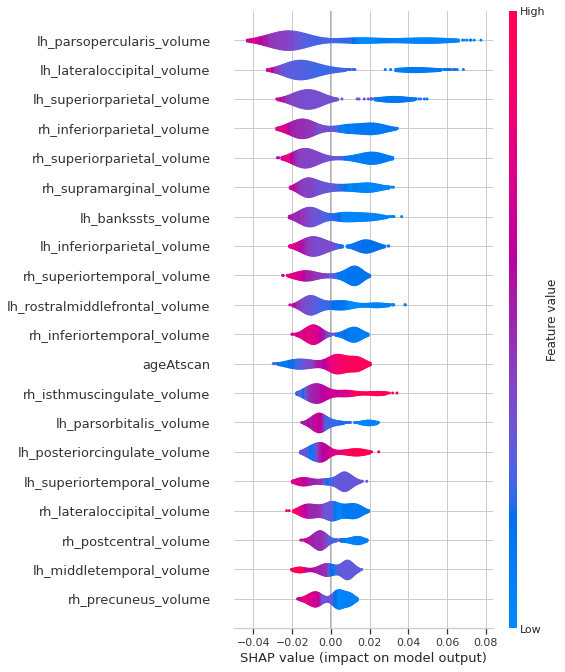

In [45]:
data = patients.iloc[:, included + [0] +[267]]
[X, y, X_test, y_test, model] = Train_model(data , RandomForestClassifier(random_state = 68, 
                           n_estimators=200, max_features= 'sqrt' , min_samples_leaf =10, bootstrap=True))
                   
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[0], X ,plot_type='violin')
#[patients['cohort'] != 'PREDICT-HD']

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train , max_display = 30)
#[patients['cohort'] != 'PREDICT-HD']

Cross Validation

size:  (520, 170)
Validation Accuracy : 0.81  ±  0.05
Validation Precision : 0.83  ±  0.09
Validation Recall : 0.82  ±  0.04


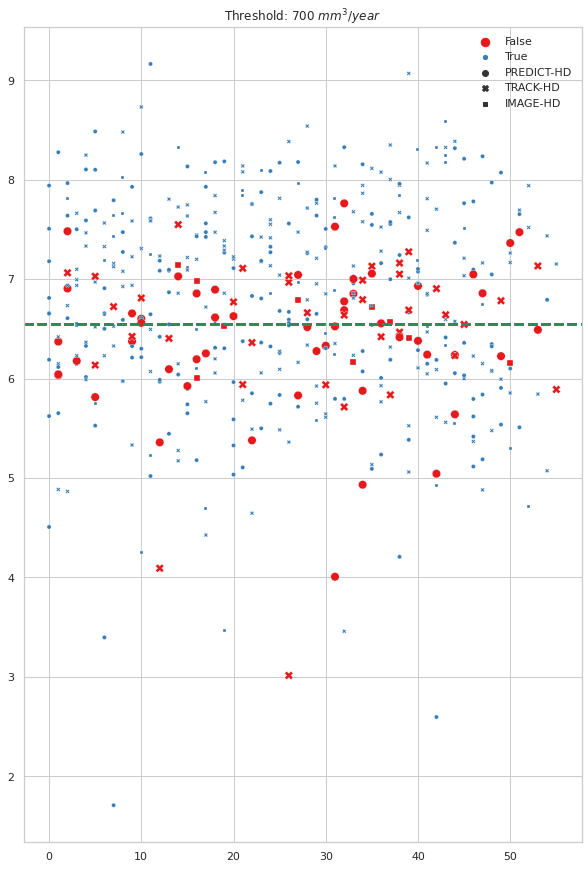

In [34]:
sns.set_theme(style="whitegrid", palette="Set1")
# sns.set_context("poster")

# X = patients[patients['group']=='symp-HD'].iloc[:, included + [0] +[267]]
X = patients.iloc[:, included + [0] +[267] + [259]]
X = X.reset_index(drop = True)

y = X['Ventricle-slope'].values
threshold = 700 # np.median(y) 

groups = X ['subjid']
X = X.drop(columns = ['Ventricle-slope', 'subjid'])  
print('size: ', X.shape)

model = RandomForestClassifier(random_state = 68,  n_estimators=200, max_features= 'sqrt' , min_samples_leaf =5, bootstrap=True)
                               
y_cat = pd.qcut(y, 20, labels=range(20))
# plt.plot(y,y_cat,'.')

skf_gen = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state= 68).split(X, y_cat , groups= groups)

metric0 = []
metric1 = []
metric2 = []
plt.figure(figsize=(10,15))
i = 0

for train, test in skf_gen:
    X_test = X.iloc[test,:]  
    y_test = y[test]
    slope_test = y_test
    y_test = y_test > threshold
    cohort_test = X_test['cohort']
    X_test = X_test.drop(columns = ['cohort'])  
    
    X_train = X.iloc[train,:]  
    y_train = y[train]
    y_train = y_train > threshold
    X_train = X_train.drop(columns = ['cohort']) 
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    marker_code = (y_test == pred)
    h = sns.scatterplot(np.arange(len(slope_test)) , np.log(slope_test), hue=marker_code, size = marker_code,
                        style= cohort_test, legend=True if i == 0 else False)
    plt.axhline(y=np.log(threshold), color ='seagreen' , ls='--', lw=2.5)
    i +=1

    # print('Test Accuracy:   %0.2f' %accuracy_score(y_test,pred))
    # print('Test f1:  %0.2f' %f1_score(y_test,pred))

    metric0.append(accuracy_score(y_test,pred))
    metric1.append(precision_score(y_test,pred))
    metric2.append(recall_score(y_test,pred))

plt.title('Threshold: %i $mm^3/year$' %threshold)
plt.legend(loc='lower right')
plt.legend(frameon=False)

print("Validation Accuracy : %0.2f  \u00B1  %0.2f" % (np.mean(metric0)  ,  np.std(metric0)))
print("Validation Precision : %0.2f  \u00B1  %0.2f" % (np.mean(metric1)  ,  np.std(metric1)))
print("Validation Recall : %0.2f  \u00B1  %0.2f" % (np.mean(metric2)  ,  np.std(metric2)))

In [35]:
X.groupby([ 'cohort']).count()

,isMale,isFemale,ageAtscan,CAP,TMS,SDMT,SWR,Lateral-Ventricle,Inf-Lat-Vent,3rd-Ventricle,...,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume
cohort,,,,,,,,,,,,,,,,,,,,,
IMAGE-HD,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
PREDICT-HD,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111
TRACK-HD,345,345,345,345,345,345,345,345,345,345,...,345,345,345,345,345,345,345,345,345,345


In [46]:
values = list(pd.DataFrame(shap_values[0]).abs().mean(0))
keys = list(X.columns)

for i, region in enumerate(keys):
    if "volume" in region:
        [side, name, measure] = region.split("_")
        if side =='lh':
            keys[i] = name + '_left'
        elif side =='rh':
            keys[i] = name + '_right'
    elif "-" in region:
        keys[i] =  "Left-" + keys[i]

ggseg_dict = dict(map(lambda i,j : (i,j) , keys,values))

print(ggseg_dict)


{'isMale': 0.00032050704859673014, 'isFemale': 0.0003923020085164252, 'ageAtscan': 0.010156326505470947, 'bankssts_left': 0.012209862163456073, 'caudalanteriorcingulate_left': 0.002689856829450547, 'caudalmiddlefrontal_left': 0.003676252757538494, 'cuneus_left': 0.0038986409507014066, 'entorhinal_left': 0.002626838515233429, 'fusiform_left': 0.0027683319323420844, 'inferiorparietal_left': 0.01205519631240906, 'inferiortemporal_left': 0.004407360993918165, 'isthmuscingulate_left': 0.005750347645294811, 'lateraloccipital_left': 0.021372811613128893, 'lateralorbitofrontal_left': 0.006635010489859735, 'lingual_left': 0.0068415104836553895, 'medialorbitofrontal_left': 0.0026694967955864734, 'middletemporal_left': 0.007549316196321362, 'parahippocampal_left': 0.004755692736529259, 'paracentral_left': 0.0012978521324768211, 'parsopercularis_left': 0.027186477372610096, 'parsorbitalis_left': 0.008615912050460209, 'parstriangularis_left': 0.004411916322796641, 'pericalcarine_left': 0.0024843024

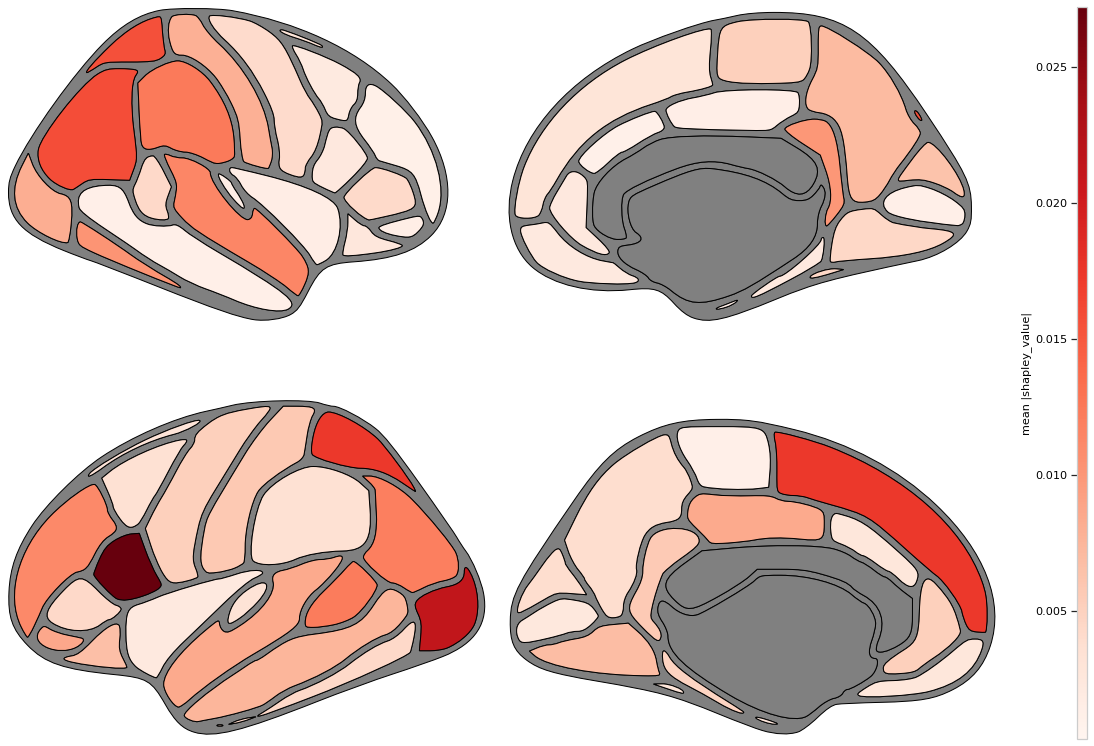

In [47]:
ggseg.plot_dk(ggseg_dict, cmap='Reds', figsize=(15,15),
              background='w', edgecolor='k', bordercolor='gray',
              ylabel='mean |shapley_value|', title='')

In [42]:
values = list(pd.DataFrame(shap_values[0]).abs().mean(0))
values = values/np.max(values)

keys = list(X.columns)

for i, region in enumerate(keys):
    if "thickness" in region:
        [side, name, measure] = region.split("_")
        if side =='lh':
            keys[i] = name + '_left'
        elif side =='rh':
            keys[i] = name + '_right'
    elif "-" in region:
        keys[i] =  "Left-" + keys[i]

ggseg_dict = dict(map(lambda i,j : (i,j) , keys,values))

print(ggseg_dict)


{'isMale': 0.039464694781409036, 'isFemale': 0.038502162964321365, 'ageAtscan': 0.30141177039496253, 'bankssts_left': 0.14665744730780106, 'caudalanteriorcingulate_left': 0.06228123555848265, 'caudalmiddlefrontal_left': 0.16554337284645537, 'cuneus_left': 0.1547986313942988, 'entorhinal_left': 0.07053111504863817, 'fusiform_left': 0.20282058032114944, 'inferiorparietal_left': 1.0, 'inferiortemporal_left': 0.04876206677910254, 'isthmuscingulate_left': 0.0875708806491043, 'lateraloccipital_left': 0.34406099817396324, 'lateralorbitofrontal_left': 0.0765375197463841, 'lingual_left': 0.16002768884899096, 'medialorbitofrontal_left': 0.15407379873582402, 'middletemporal_left': 0.28196247362744126, 'parahippocampal_left': 0.16591078807537565, 'paracentral_left': 0.2471992406978768, 'parsopercularis_left': 0.4426571625430615, 'parsorbitalis_left': 0.050632514251199925, 'parstriangularis_left': 0.12278497769131612, 'pericalcarine_left': 0.107714428781637, 'postcentral_left': 0.15136330001312942,

In [43]:
del ggseg_dict['isMale']
del ggseg_dict['isFemale']
del ggseg_dict['ageAtscan']
# ggseg_dict

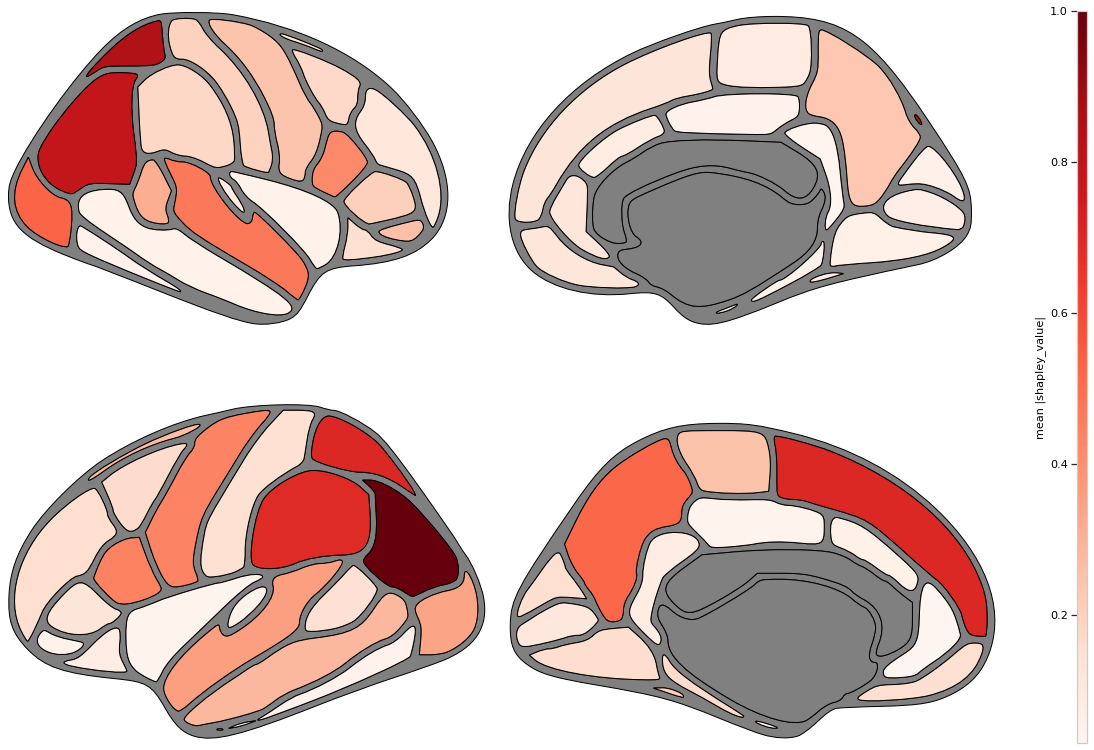

In [44]:
ggseg.plot_dk(ggseg_dict, cmap='Reds', figsize=(15,15),
              background='w', edgecolor='k', bordercolor='gray',
              ylabel='mean |shapley_value|', title='')